<a href="https://colab.research.google.com/github/dukisima/cross-device-model-testing/blob/main/notebooks/main_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Connect to git and load libs

In [1]:
#Cloning the repo to access databases
!git clone https://github.com/dukisima/cross-device-model-testing.git repo
%cd repo


Cloning into 'repo'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 54 (delta 16), reused 27 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 22.95 MiB | 21.88 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/repo


In [2]:
import pandas as pd
import numpy as np


#Libraries for model training
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
import joblib  # For saving the model

#Libs for displaying results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns




#Load and check DataFrame


In [3]:
# Load the dataset only once (avoid reloading on every "Run all" since it’s slow)
if 'df' not in globals():
    # In Colab: absolute path inside the mounted repo
    df = pd.read_excel('/content/repo/data/Final_DB_noPre_40x40.xlsx')
    # On a local machine (e.g., PyCharm), you might use: df = pd.read_excel('data/Final_DB_noPre_40x40.xlsx')
else:
    print("Dataset already loaded")

# Quick peek at the first rows to verify the load worked
df.head()

,study_id,image_id,Image Name,grid_box,overlap,class,Patient's Age,View Position,Image Laterality,Photometric Interpretation,...,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
0,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,100f9f1f5392774416f1a1e66a5a4c71.dicom,"(519, 1249, 559, 1289)",0.0625,1,040Y,MLO,L,MONOCHROME2,...,160.59000,8.892423,81.291250,12.99250,993.002500,0.288646,0.023113,0.195380,16.343036,0.005644
1,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,100f9f1f5392774416f1a1e66a5a4c71.dicom,"(559, 1249, 599, 1289)",0.2500,1,040Y,MLO,L,MONOCHROME2,...,171.97500,6.523694,85.422500,12.01125,1021.472500,0.203774,0.019353,0.241500,20.944358,0.006154
2,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,100f9f1f5392774416f1a1e66a5a4c71.dicom,"(599, 1249, 639, 1289)",0.1875,1,040Y,MLO,L,MONOCHROME2,...,222.79125,4.028140,33.805625,11.78250,374.535625,0.659009,0.060646,0.232860,8.439855,0.019293
3,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,100f9f1f5392774416f1a1e66a5a4c71.dicom,"(519, 1289, 559, 1329)",0.2500,1,040Y,MLO,L,MONOCHROME2,...,173.53875,7.025171,69.721875,11.78000,796.599375,0.280104,0.026575,0.225163,16.410903,0.007896
4,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,100f9f1f5392774416f1a1e66a5a4c71.dicom,"(559, 1289, 599, 1329)",1.0000,1,040Y,MLO,L,MONOCHROME2,...,118.00000,14.339244,143.105000,10.06875,1396.027500,0.127720,0.013833,0.284340,42.178285,0.004248


In [4]:
df.dtypes
df.shape #should be(14772, 152)

(14772, 152)

#Preparing the DataFrame


##Exclude all non-numeric/object columns


In [5]:
# Keep only numeric columns (exclude all non-numeric/object columns)
df_numericka = df.select_dtypes(exclude=['object'])
kolone_za_zadrzavanje = ['study_id', 'image_id', 'Manufacturer']

# Combine selected ID/metadata columns with numeric columns
df_cleaned = pd.concat([df[kolone_za_zadrzavanje], df_numericka], axis=1)
df_cleaned = df_cleaned.drop(['Rows', 'Columns', 'width'], axis=1)
df_cleaned.head()

,study_id,image_id,Manufacturer,overlap,class,Pixel Padding Value,Pixel Padding Range Limit,Window Center,Window Width,Rescale Intercept,...,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
0,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.0625,1,0,NaN,1656.0,1500.0,0,...,160.59000,8.892423,81.291250,12.99250,993.002500,0.288646,0.023113,0.195380,16.343036,0.005644
1,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.2500,1,0,NaN,1656.0,1500.0,0,...,171.97500,6.523694,85.422500,12.01125,1021.472500,0.203774,0.019353,0.241500,20.944358,0.006154
2,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.1875,1,0,NaN,1656.0,1500.0,0,...,222.79125,4.028140,33.805625,11.78250,374.535625,0.659009,0.060646,0.232860,8.439855,0.019293
3,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.2500,1,0,NaN,1656.0,1500.0,0,...,173.53875,7.025171,69.721875,11.78000,796.599375,0.280104,0.026575,0.225163,16.410903,0.007896
4,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,1.0000,1,0,NaN,1656.0,1500.0,0,...,118.00000,14.339244,143.105000,10.06875,1396.027500,0.127720,0.013833,0.284340,42.178285,0.004248


##Correcting the "overlap" feature






In [6]:
#Correcting the mistake I mede when I was making the database

In [7]:
# For every sample with class = 0 (healthy), set the 'overlap' value to 0
df_cleaned.loc[df_cleaned['class'] == 0, 'overlap'] = 0


In [8]:
df_cleaned.head(10)

,study_id,image_id,Manufacturer,overlap,class,Pixel Padding Value,Pixel Padding Range Limit,Window Center,Window Width,Rescale Intercept,...,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
0,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.0625,1,0,NaN,1656.0,1500.0,0,...,160.59000,8.892423,81.291250,12.99250,993.002500,0.288646,0.023113,0.195380,16.343036,0.005644
1,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.2500,1,0,NaN,1656.0,1500.0,0,...,171.97500,6.523694,85.422500,12.01125,1021.472500,0.203774,0.019353,0.241500,20.944358,0.006154
2,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.1875,1,0,NaN,1656.0,1500.0,0,...,222.79125,4.028140,33.805625,11.78250,374.535625,0.659009,0.060646,0.232860,8.439855,0.019293
3,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.2500,1,0,NaN,1656.0,1500.0,0,...,173.53875,7.025171,69.721875,11.78000,796.599375,0.280104,0.026575,0.225163,16.410903,0.007896
4,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,1.0000,1,0,NaN,1656.0,1500.0,0,...,118.00000,14.339244,143.105000,10.06875,1396.027500,0.127720,0.013833,0.284340,42.178285,0.004248
5,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.7500,1,0,NaN,1656.0,1500.0,0,...,105.13125,17.767262,142.969375,10.42750,1429.543125,0.175898,0.016517,0.260196,39.699879,0.004321
6,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.2250,1,0,NaN,1656.0,1500.0,0,...,131.79125,14.505593,114.393125,11.19375,1220.165625,0.180702,0.016683,0.239746,28.105662,0.004478
7,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.9000,1,0,NaN,1656.0,1500.0,0,...,153.47125,8.646236,98.967500,10.38000,1003.835000,0.180979,0.018006,0.249874,25.923594,0.004445
8,4e6f6c5e70433a176643f635747a328d,100f9f1f5392774416f1a1e66a5a4c71,SIEMENS,0.6750,1,0,NaN,1656.0,1500.0,0,...,186.99875,6.061798,52.591250,12.71750,641.223750,0.442654,0.037218,0.220294,12.456568,0.009724
9,4e6f6c5e70433a176643f635747a328d,a4891d2838d60a3b7442a90bbb53102a,SIEMENS,0.0000,0,0,NaN,1673.0,1500.0,0,...,223.15375,4.018528,36.815625,11.92750,415.375625,0.589549,0.056443,0.223192,8.655063,0.018280


In [9]:
df_cleaned.loc[df_cleaned['class'] == 1, 'overlap'].describe() #Mean of overlap feature is 0.754

,overlap
count,7498.000000
mean,0.754064
std,0.351211
min,0.006250
25%,0.250000
50%,1.000000
75%,1.000000
max,1.000000


## Handling classes with samples


In [10]:
# Set so that if 'overlap' is below a threshold, mark class as 0 (healthy tissue)

In [11]:
# df_cleaned.loc[df_cleaned['overlap'] < 0.01, 'class'] = 0

df_cleaned = df_cleaned[(df_cleaned['overlap'] == 0) | (df_cleaned['overlap'] >= 0.01)]  # drop very small overlaps

df_cleaned.head()
df_cleaned.shape

(14761, 114)

## Removing NaN values


In [12]:
# Drop all columns that have more than 2% NaN values

def drop_columns_with_nan_threshold(df, threshold=0.02):
    nan_ratio = df.isna().mean()  # percentage of NaN values per column
    cols_to_drop = nan_ratio[nan_ratio > threshold].index  # columns above threshold
    print(f"{len(cols_to_drop)} columns will be dropped: {list(cols_to_drop)}")
    return df.drop(columns=cols_to_drop)

df_cleaned = drop_columns_with_nan_threshold(df_cleaned)
df_cleaned.head()
df_cleaned.shape
# Columns to drop: ['Pixel Padding Range Limit', 'Window Center', 'Window Width', 'xmin', 'ymin', 'xmax', 'ymax']


7 columns will be dropped: ['Pixel Padding Range Limit', 'Window Center', 'Window Width', 'xmin', 'ymin', 'xmax', 'ymax']


(14761, 107)

## Function for moving a column to a new position


In [13]:
def move_column_to_position(df, column_name, position):
    cols = list(df.columns)
    cols.remove(column_name)
    cols.insert(position, column_name)
    return df[cols]

# move_column_to_position(df_cleaned, 'adjusted_label', 4)


## Removing const features


In [14]:
# df_cleaned.loc[:, df_cleaned.nunique(dropna=False) > 2] #If these is one or two unique values

## Splitting the DataFrame by manufacturers


In [15]:
df_cleaned['Manufacturer'].unique() #['SIEMENS', 'Planmed', 'IMS s.r.l.', 'IMS GIOTTO S.p.A.']

array(['SIEMENS', 'Planmed', 'IMS s.r.l.', 'IMS GIOTTO S.p.A.'],
      dtype=object)

In [16]:
unique_manufacturers = df_cleaned['Manufacturer'].unique()

df_by_manufacturer = {
    manufacturer: df_cleaned[df_cleaned['Manufacturer'] == manufacturer].copy()
    for manufacturer in unique_manufacturers
}

# Now we have 4 DataFrames, e.g.:
df_SIEMENS   = df_by_manufacturer[unique_manufacturers[0]]
df2_Planmed  = df_by_manufacturer[unique_manufacturers[1]]
df3_IMS      = df_by_manufacturer[unique_manufacturers[2]]
df4_IMSGIOTTO = df_by_manufacturer[unique_manufacturers[3]]

In [46]:
print("Number of SIEMENS images: ", df_SIEMENS.shape[0])
print("Number of Planmed images: ", df2_Planmed.shape[0])
print("Number of IMS images: ", df3_IMS.shape[0])
print("Number of IMSGIOTTO images: ", df4_IMSGIOTTO.shape[0])

Number of SIEMENS images:  4497
Number of Planmed images:  5799
Number of IMS images:  3703
Number of IMSGIOTTO images:  762


Text(0.5, 1.0, 'Class distribution')

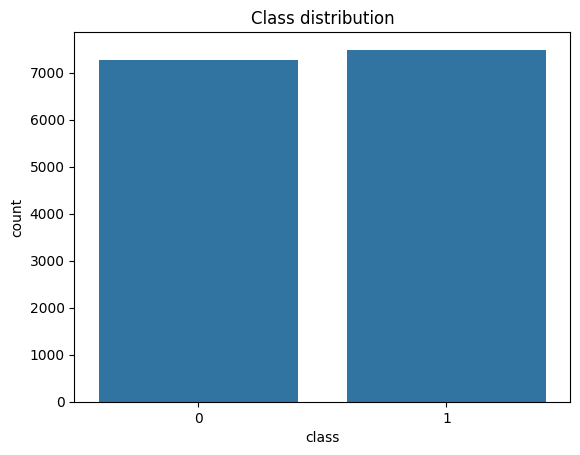

In [17]:
# Plot distribution of classes
sns.countplot(x='class', data=df_cleaned)
plt.title('Class distribution')
# plt.show()

# approximately balanced classes

In [18]:
#remove this features and split DFs complitaly
cols_to_drop = ['Manufacturer','zero_overlap_diseased_breast', 'overlap']

df_SIEMENS = df_SIEMENS.drop(columns=cols_to_drop, errors='ignore')
df2_Planmed = df2_Planmed.drop(columns=cols_to_drop, errors='ignore')
df3_IMS = df3_IMS.drop(columns=cols_to_drop, errors='ignore')
df4_IMSGIOTTO = df4_IMSGIOTTO.drop(columns=cols_to_drop, errors='ignore')
df_cleaned = df_cleaned.drop(columns=cols_to_drop, errors='ignore')

# Train the model on the first DF

## Split into train, val, test

In [21]:
# Ensure the same study_id does not appear in multiple splits

def split_dataframe_to_TVT(df, id_column='study_id', train_size=0.8, val_size=0.08, test_size=0.12, random_state=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Sum of sizes must be 1.0"

    unique_ids = df[id_column].unique()

    if val_size == 0:
        # Only train/test split by unique IDs
        train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=random_state)
        df_train = df[df[id_column].isin(train_ids)].copy()
        df_test  = df[df[id_column].isin(test_ids)].copy()
        df_val   = pd.DataFrame(columns=df.columns)  # empty DataFrame
    else:
        # Train/val/test split by unique IDs
        train_ids, temp_ids = train_test_split(unique_ids, test_size=(1 - train_size), random_state=random_state)
        val_ids, test_ids = train_test_split(temp_ids, test_size=test_size / (test_size + val_size), random_state=random_state)

        df_train = df[df[id_column].isin(train_ids)].copy()
        df_val   = df[df[id_column].isin(val_ids)].copy()
        df_test  = df[df[id_column].isin(test_ids)].copy()

    return df_train, df_val, df_test

## K-fold split


In [ ]:
#Testiranjem sam pronašao da je ovo najbolji nacin podele na train,val,test

In [22]:
# Through testing, this proved to be the best way to split into train/val/test
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd

data_frame = df_cleaned

# Exclude label/ID columns from features
X = data_frame[[col for col in data_frame.columns if col not in ['class', 'overlap', 'study_id', 'image_id']]]
y = data_frame['class']
groups = data_frame['study_id']

# First split into TrainVal (85%) and Test (15%)
sgkf_outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

for trainval_idx, test_idx in sgkf_outer.split(X, y, groups):
    X_trainval, X_test = X.iloc[trainval_idx], X.iloc[test_idx]
    y_trainval, y_test = y.iloc[trainval_idx], y.iloc[test_idx]
    groups_trainval = groups.iloc[trainval_idx]
    break  # take the first split

# Then split TrainVal into Train (80%) and Validation (20%)
sgkf_inner = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=24)

for train_idx, val_idx in sgkf_inner.split(X_trainval, y_trainval, groups_trainval):
    X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
    break  # take the first split

# --- Size check:
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 7829 samples
Validation set: 2512 samples
Test set: 4420 samples


## Computing weight coeff (not used)

In [ ]:
# We decided not to include this for now

In [23]:
# This part computes weights for class 1 proportional to how much a sample overlaps with the lesion
def calculate_weights(row):
    if row['class'] == 1:
        return row['overlap']  # use overlap as the weight
    else:
        return 1.0  # healthy tissue -> weight 1

# sample_weights = df_train.apply(calculate_weights, axis=1)  # we would pass these into fit later

##Training and eval

In [25]:
# Training the model

clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Note: to use sample weights later, pass sample_weight=sample_weights here
clf.fit(X_train, y_train)

# I tested XGBoost, LightGBM, and GradientBoosting; classic RandomForest performs best so far

RandomForestClassifier(random_state=42)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# === VALIDATION ===
y_val_pred  = clf.predict(X_val)
y_val_proba = clf.predict_proba(X_val)[:, 1]  # for AUC

print("=== VALIDATION ===")
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_val_pred))
# print("\nClassification Report (Validation):")
# print(classification_report(y_val, y_val_pred))
print(f"ROC AUC (Validation): {roc_auc_score(y_val, y_val_proba):.4f}")

# === TEST ===
y_test_pred  = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

print("\n=== TEST ===")
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))
# print("\nClassification Report (Test):")
# print(classification_report(y_test, y_test_pred))
print(f"ROC AUC (Test): {roc_auc_score(y_test, y_test_proba):.4f}")

=== VALIDATION ===
Confusion Matrix (Validation):
[[585 637]
 [427 863]]
ROC AUC (Validation): 0.6402

=== TEST ===
Confusion Matrix (Test):
[[1160 1042]
 [ 621 1597]]
ROC AUC (Test): 0.6830


In [27]:
kolone_za_zadrzavanje = ['overlap']  # keep overlap column for later dataset splits
df_celaned_prosiren = pd.concat([df[kolone_za_zadrzavanje], df_cleaned], axis=1)
df_celaned_prosiren.head()

# For class = 0, set overlap to 0
df_celaned_prosiren.loc[df['class'] == 0, 'overlap'] = 0

In [28]:
# Extract overlap values for class 0 and check uniqueness
overlap_klasa_0 = df_celaned_prosiren.loc[df_celaned_prosiren['class'] == 0, 'overlap']
overlap_klasa_0.unique()

array([0.])

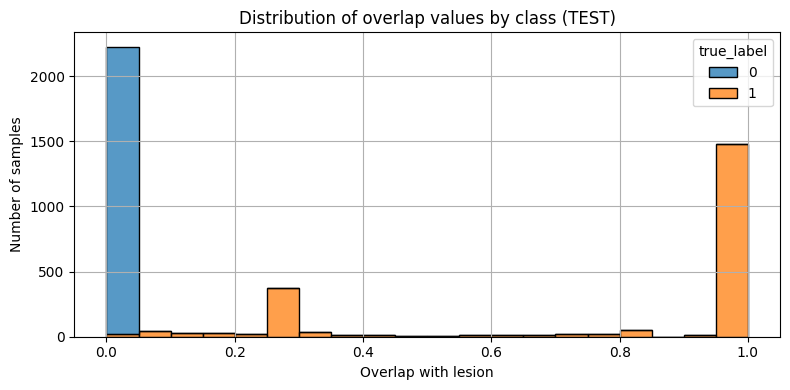

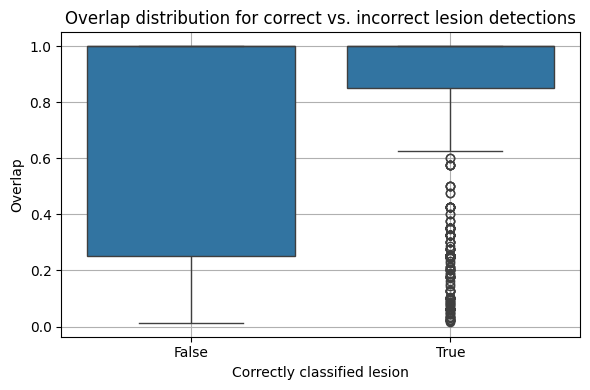

In [29]:
# === ADDITIONAL ERROR ANALYSIS ===
# Pull overlap and meta-info from the original dataframe
X_test_with_meta = X_test.copy()
X_test_with_meta['true_label'] = y_test.values
X_test_with_meta['y_pred'] = y_test_pred
X_test_with_meta['y_proba'] = y_test_proba
X_test_with_meta['overlap'] = df_celaned_prosiren.loc[X_test.index, 'overlap'].values
X_test_with_meta['study_id'] = df_celaned_prosiren.loc[X_test.index, 'study_id'].values
X_test_with_meta['image_id'] = df_celaned_prosiren.loc[X_test.index, 'image_id'].values

# === Review false negatives (class=1, pred=0)
false_negatives = X_test_with_meta[(X_test_with_meta['true_label'] == 1) & (X_test_with_meta['y_pred'] == 0)]

# === Review false positives (class=0, pred=1)
false_positives = X_test_with_meta[(X_test_with_meta['true_label'] == 0) & (X_test_with_meta['y_pred'] == 1)]

# === Overlap distribution visualization
plt.figure(figsize=(8, 4))
sns.histplot(data=X_test_with_meta, x='overlap', hue='true_label', bins=20, kde=False, multiple='stack')
plt.title("Distribution of overlap values by class (TEST)")
plt.xlabel("Overlap with lesion")
plt.ylabel("Number of samples")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Boxplot of overlap by classification correctness (lesion-only)
X_test_with_meta['correct'] = X_test_with_meta['true_label'] == X_test_with_meta['y_pred']
lesion_only = X_test_with_meta[X_test_with_meta['true_label'] == 1]

plt.figure(figsize=(6, 4))
sns.boxplot(data=lesion_only, x='correct', y='overlap')
plt.title("Overlap distribution for correct vs. incorrect lesion detections")
plt.xlabel("Correctly classified lesion")
plt.ylabel("Overlap")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Here we see that the false calssifications happend more when overlap is less than 0.9 which makes sense as
#that tissue is neather heathy nor malignant

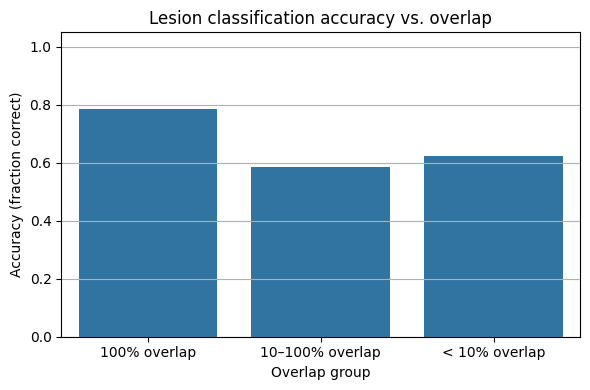

In [30]:
# Filter only unhealthy (lesion) samples
lesion_cases = X_test_with_meta[X_test_with_meta['true_label'] == 1].copy()

# Add categorical overlap group
lesion_cases['overlap_group'] = lesion_cases['overlap'].apply(
    lambda x: '100% overlap' if x == 1.0 else ('< 10% overlap' if x < 0.1 else '10–100% overlap')
)

# Accuracy per overlap group
accuracy_by_group = lesion_cases.groupby('overlap_group')['correct'].mean().reset_index()

# Bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=accuracy_by_group, x='overlap_group', y='correct')
plt.title("Lesion classification accuracy vs. overlap")
plt.ylabel("Accuracy (fraction correct)")
plt.xlabel("Overlap group")
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

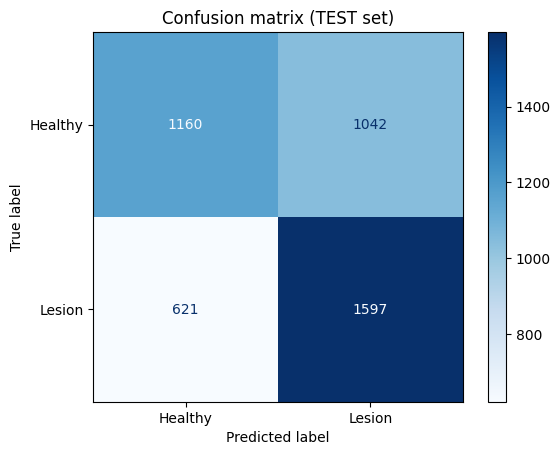

In [31]:
# Confusion matrix (TEST)
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Lesion"])
disp.plot(cmap='Blues')
plt.title("Confusion matrix (TEST set)")
plt.show()

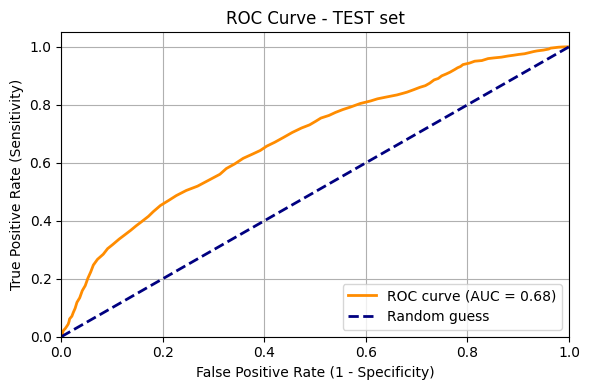

In [32]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - TEST set')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Displaying the most important features


Top Features:
                                 Feature  Importance
4       diagnostics_Image-original_Mean    0.119239
5    diagnostics_Image-original_Minimum    0.073835
6    diagnostics_Image-original_Maximum    0.040158
10     original_firstorder_90Percentile    0.023411
22  original_firstorder_RootMeanSquared    0.023069
18           original_firstorder_Median    0.022979
24      original_firstorder_TotalEnergy    0.022319
17             original_firstorder_Mean    0.022213
11           original_firstorder_Energy    0.021492
19          original_firstorder_Minimum    0.019289


/tmp/ipython-input-3927068116.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


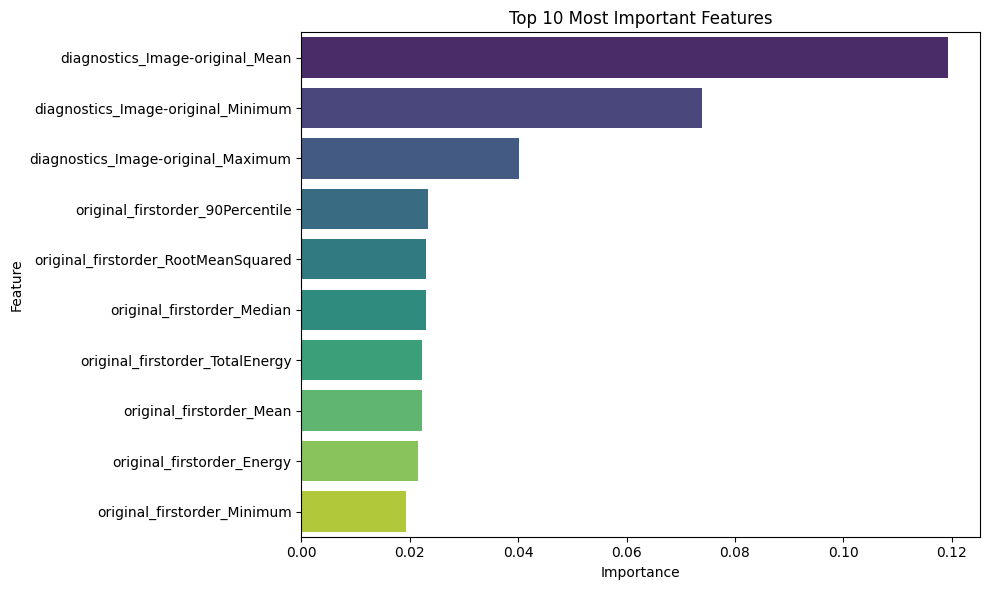

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute feature importance
feature_importances = clf.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 2. Top 10 most important features
top_features = importance_df.head(10)
print("Top Features:\n", top_features)

# 3. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.savefig('top_features.png')
plt.show()

# 4. Save into a list
top_feature_list = top_features['Feature'].tolist()


##How to save the model

In [34]:
# Saving the model
joblib.dump(clf, 'random_forest_df_SIEMENS_model.pkl')
print("Model saved as 'random_forest_df_SIEMENS_model.pkl'")

# Loading the model
clf_old = joblib.load('random_forest_df_SIEMENS_model.pkl')
print("Model successfully loaded.")

Model saved as 'random_forest_df_SIEMENS_model.pkl'
Model successfully loaded.


# Cross-testing models (using TVT)

In [ ]:
# For each dataset (4 manufacturers), the model is trained and then tested on all other datasets

In [35]:
###############################
if 'all_importances' in locals():
    del all_importances  # clear if already defined to avoid conflicts
###############################


datasets = {
    # 'Full_DB': df_cleaned,  # optional: train/test on the full dataset
    'SIEMENS': df_SIEMENS,
    'Planmed': df2_Planmed,
    'IMS': df3_IMS,
    'IMSGIOTTO': df4_IMSGIOTTO
}

# Store all results
auc_scores = pd.DataFrame(index=datasets.keys(), columns=datasets.keys())
f1_scores = pd.DataFrame(index=datasets.keys(), columns=datasets.keys())

for train_name, train_df in datasets.items():
    # Train/test split by patient IDs
    df_train, df_val_unused, df_test = split_dataframe_to_TVT(
        train_df, id_column='study_id', train_size=0.8, val_size=0.0, test_size=0.2, random_state=42
    )

    # Prepare data
    X_train = df_train[[col for col in df_train.columns if col not in ['class', 'overlap', 'study_id', 'image_id']]]
    y_train = df_train['class']

    X_test_split = df_test[[col for col in df_test.columns if col not in ['class', 'overlap', 'study_id', 'image_id']]]
    y_test_split = df_test['class']

    # Train model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Save feature importances
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        f'Importance_{train_name}': clf.feature_importances_
    }).set_index('Feature')

    if 'all_importances' not in locals():
        all_importances = feature_importances
    else:
        all_importances = all_importances.join(feature_importances, how='outer')

    # Test on each dataset
    for test_name, test_df in datasets.items():
        if test_name == train_name:
            X_test_final = X_test_split
            y_test_final = y_test_split
        else:
            X_test_final = test_df[[col for col in test_df.columns if col not in ['class', 'overlap', 'study_id', 'image_id']]]
            y_test_final = test_df['class']

        y_pred = clf.predict(X_test_final)
        y_proba = clf.predict_proba(X_test_final)[:, 1]

        auc = roc_auc_score(y_test_final, y_proba)
        f1 = f1_score(y_test_final, y_pred)

        auc_scores.loc[train_name, test_name] = auc
        f1_scores.loc[train_name, test_name] = f1

# Convert to float
auc_scores = auc_scores.astype(float)
f1_scores = f1_scores.astype(float)



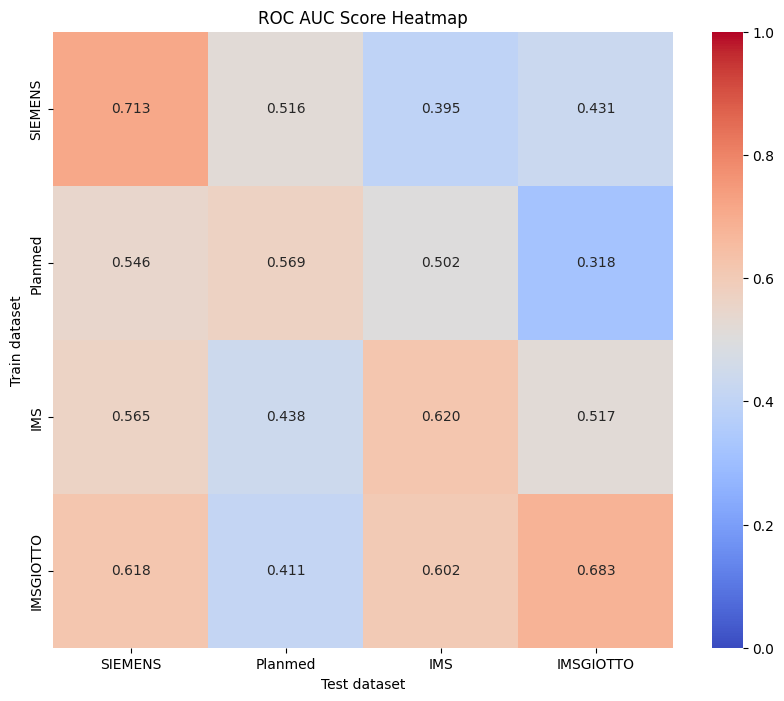

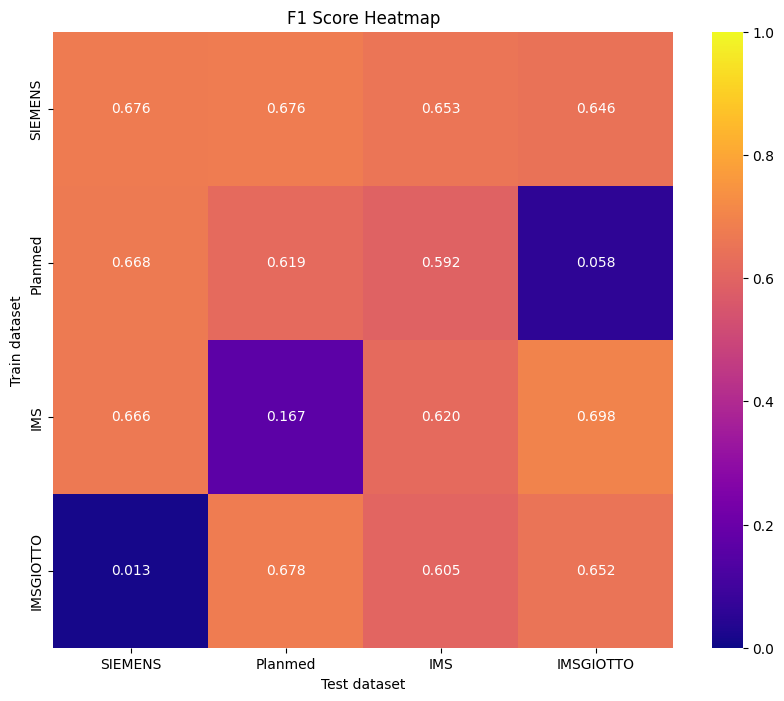

/tmp/ipython-input-2587134370.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features['Mean_Importance'], y=top_features.index, palette="magma")


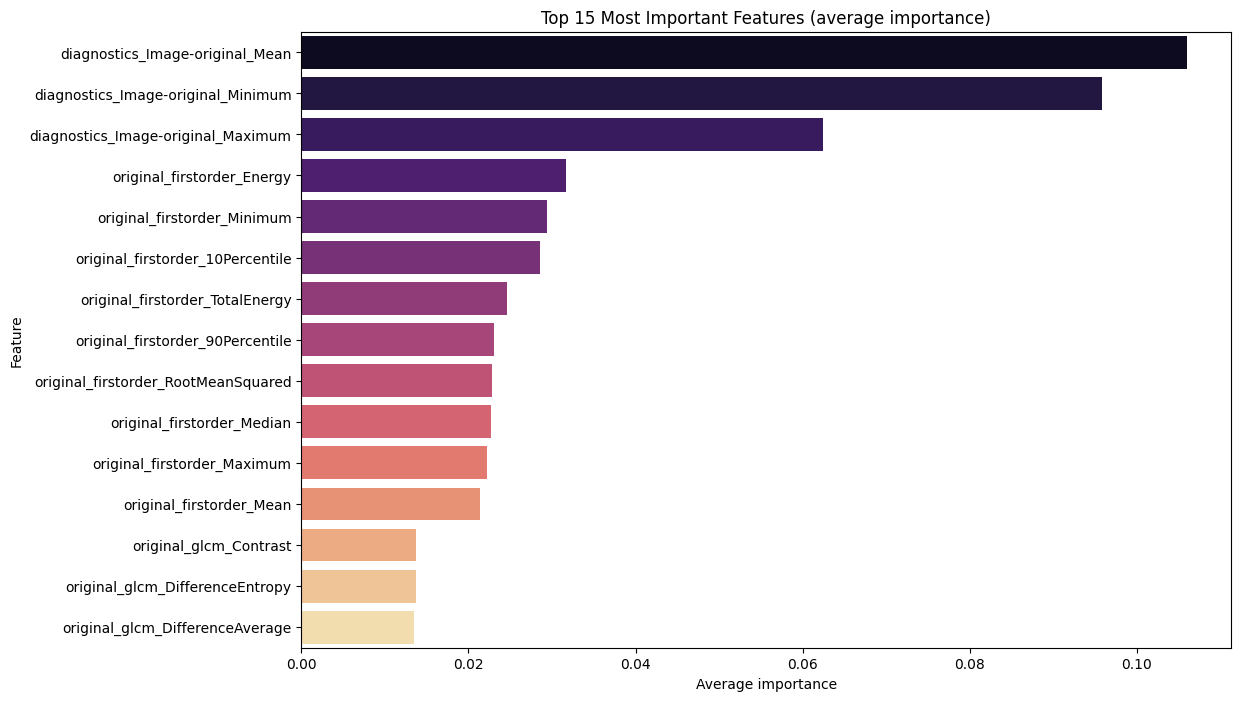

Average AUC score: 0.527835994996387


In [36]:
# --- HEATMAP PLOTS ---

plt.figure(figsize=(10, 8))
sns.heatmap(auc_scores, annot=True, fmt=".3f", cmap="coolwarm", vmin=0, vmax=1)
plt.title("ROC AUC Score Heatmap")
plt.xlabel("Test dataset")
plt.ylabel("Train dataset")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(f1_scores, annot=True, fmt=".3f", cmap='plasma', vmin=0, vmax=1)
plt.title("F1 Score Heatmap")
plt.xlabel("Test dataset")
plt.ylabel("Train dataset")
plt.show()

# --- FEATURE IMPORTANCES ---
all_importances['Mean_Importance'] = all_importances.mean(axis=1)
top_features = all_importances.sort_values('Mean_Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features['Mean_Importance'], y=top_features.index, palette="magma")
plt.title('Top 15 Most Important Features (average importance)')
plt.xlabel('Average importance')
plt.ylabel('Feature')
plt.show()

print('Average AUC score:', auc_scores.mean().mean())

# Cross-testing models (using k-fold)

In [38]:
if 'all_importances' in locals():
    del all_importances  # clear this list if the code was already run to avoid errors


datasets = {
    # 'Full_DB': df_cleaned,  # could be added to test performance on the entire dataset
    'SIEMENS': df_SIEMENS,
    'Planmed': df2_Planmed,
    'IMS': df3_IMS,
    'IMSGIOTTO': df4_IMSGIOTTO
}

# Store all results
auc_scores = pd.DataFrame(index=datasets.keys(), columns=datasets.keys())
f1_scores = pd.DataFrame(index=datasets.keys(), columns=datasets.keys())

# Loop through each dataset as a training set
for train_name, train_df in datasets.items():
    # Prepare data
    X = train_df[[col for col in train_df.columns if col not in ['class', 'overlap', 'study_id', 'image_id']]]
    y = train_df['class']
    groups = train_df['study_id']

    ####################################################################### KFold split into train/val/test
    # Split into TrainVal and Test
    sgkf_outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    for trainval_idx, test_idx in sgkf_outer.split(X, y, groups):
        X_trainval, X_test = X.iloc[trainval_idx], X.iloc[test_idx]
        y_trainval, y_test = y.iloc[trainval_idx], y.iloc[test_idx]
        groups_trainval = groups.iloc[trainval_idx]
        break  # only take the first split

    # Split TrainVal into Train and Validation
    sgkf_inner = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=24)
    for train_idx, val_idx in sgkf_inner.split(X_trainval, y_trainval, groups_trainval):
        X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
        y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        break  # only take the first split
    #######################################################################

    # Train model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Save feature importances
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        f'Importance_{train_name}': clf.feature_importances_
    }).set_index('Feature')

    if 'all_importances' not in locals():
        all_importances = feature_importances
    else:
        all_importances = all_importances.join(feature_importances, how='outer')

    # Test on each dataset
    for test_name, test_df in datasets.items():
        X_test_final = test_df[[col for col in test_df.columns if col not in ['class', 'overlap', 'study_id', 'image_id']]]
        y_test_final = test_df['class']

        # Predict
        y_pred = clf.predict(X_test_final)
        y_proba = clf.predict_proba(X_test_final)[:, 1]

        # Compute metrics
        auc = roc_auc_score(y_test_final, y_proba)
        f1 = f1_score(y_test_final, y_pred)

        auc_scores.loc[train_name, test_name] = auc
        f1_scores.loc[train_name, test_name] = f1

# Convert to float (initialized as object by pandas)
auc_scores = auc_scores.astype(float)
f1_scores = f1_scores.astype(float)


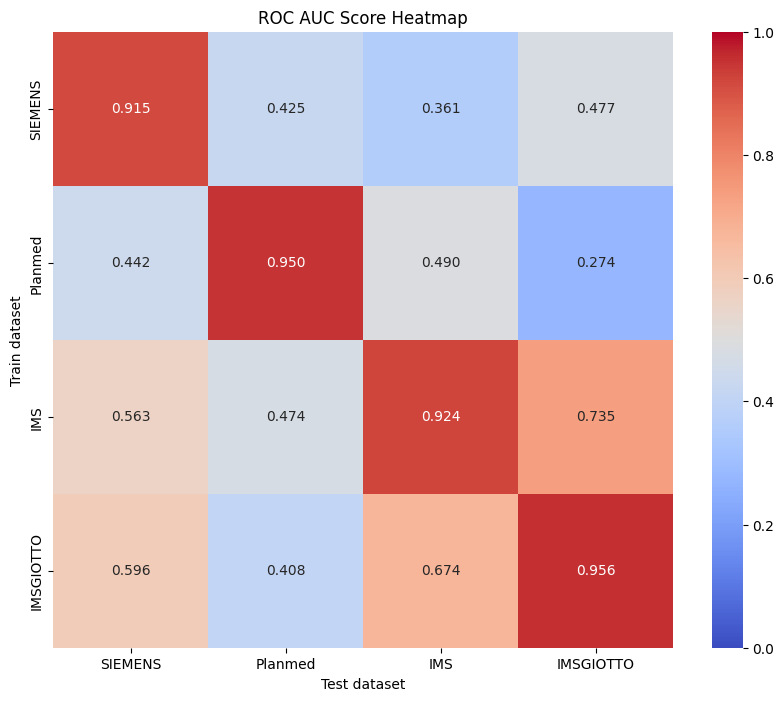

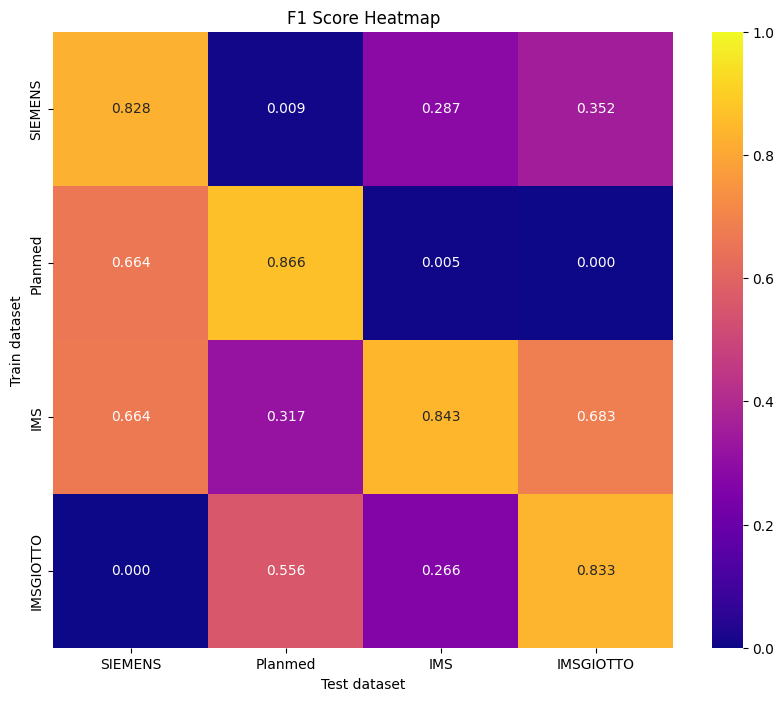

/tmp/ipython-input-2587134370.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features['Mean_Importance'], y=top_features.index, palette="magma")


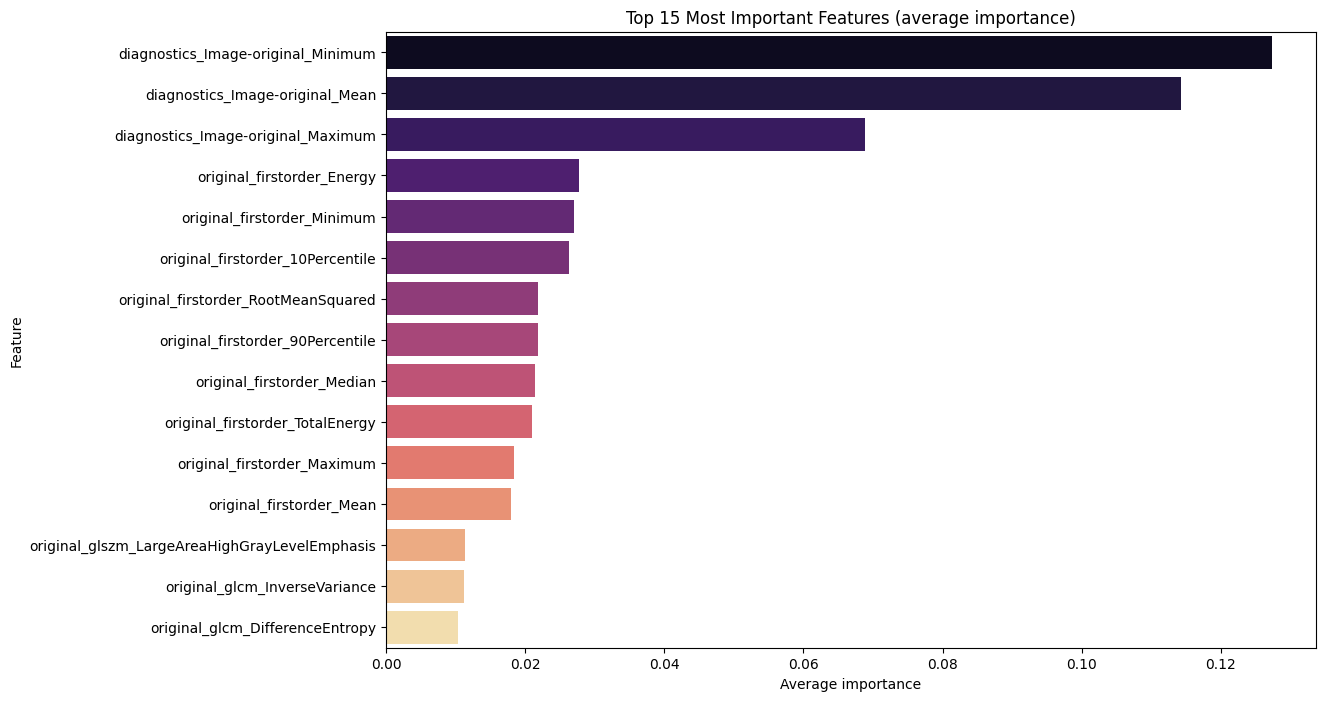

Average AUC score: 0.6041134451369652


In [39]:
# --- HEATMAP PLOTS ---

plt.figure(figsize=(10, 8))
sns.heatmap(auc_scores, annot=True, fmt=".3f", cmap="coolwarm", vmin=0, vmax=1)
plt.title("ROC AUC Score Heatmap")
plt.xlabel("Test dataset")
plt.ylabel("Train dataset")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(f1_scores, annot=True, fmt=".3f", cmap='plasma', vmin=0, vmax=1)
plt.title("F1 Score Heatmap")
plt.xlabel("Test dataset")
plt.ylabel("Train dataset")
plt.show()

# --- FEATURE IMPORTANCES ---
all_importances['Mean_Importance'] = all_importances.mean(axis=1)
top_features = all_importances.sort_values('Mean_Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features['Mean_Importance'], y=top_features.index, palette="magma")
plt.title('Top 15 Most Important Features (average importance)')
plt.xlabel('Average importance')
plt.ylabel('Feature')
plt.show()

print('Average AUC score:', auc_scores.mean().mean())

# Feature importance across all trained models

In [ ]:
# Display the top 15 features with the highest average importance

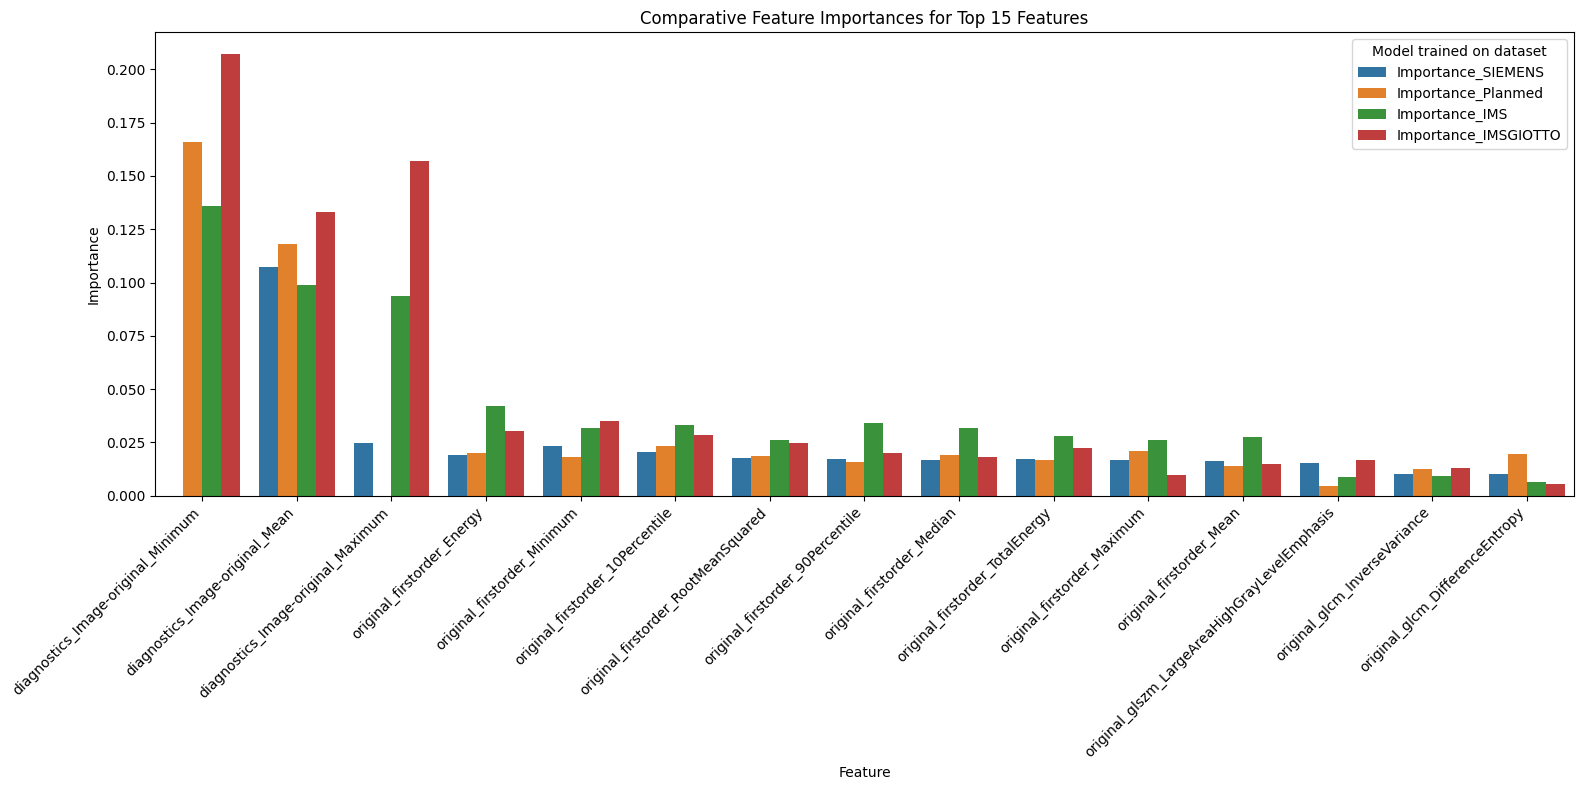

In [40]:
# 1. Select top 15 features by mean importance
top_features = all_importances['Mean_Importance'].sort_values(ascending=False).head(15).index

# 2. Keep only these features + all model-specific columns (exclude Mean_Importance)
model_columns = [col for col in all_importances.columns if col != 'Mean_Importance']
top_features_importances = all_importances.loc[top_features, model_columns]

# 3. Prepare for grouped bar plot
top_features_importances_reset = top_features_importances.reset_index().rename(columns={'index': 'Feature'})
df_melted = top_features_importances_reset.melt(id_vars='Feature', var_name='Model', value_name='Importance')

# 4. Plot grouped bar plot
plt.figure(figsize=(16, 8))
sns.barplot(data=df_melted, x='Feature', y='Importance', hue='Model')

plt.xticks(rotation=45, ha='right')
plt.title('Comparative Feature Importances for Top 15 Features')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend(title='Model trained on dataset')
plt.tight_layout()
plt.show()